0:	learn: 0.5478508	test: 0.5518372	best: 0.5518372 (0)	total: 195ms	remaining: 1m 57s
50:	learn: 0.5618992	test: 0.5630413	best: 0.5633231 (24)	total: 2.22s	remaining: 23.9s
100:	learn: 0.5628415	test: 0.5630392	best: 0.5636123 (55)	total: 4.15s	remaining: 20.5s
150:	learn: 0.5637532	test: 0.5629195	best: 0.5636123 (55)	total: 6.12s	remaining: 18.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5636123296
bestIteration = 55

Shrink model to first 56 iterations.

✅ Accuracy: 0.57385
✅ F1 Score (weighted): 0.5576628390325256
✅ Precision (weighted): 0.5676093217864352
✅ Recall (weighted): 0.57385
✅ ROC AUC (OvR): 0.7371952575337702

📊 Classification Report:
               precision    recall  f1-score   support

        High       0.53      0.55      0.54      3774
         Low       0.60      0.78      0.68      8497
    Moderate       0.55      0.36      0.43      7729

    accuracy                           0.57     20000
   macro avg       0.56      0.56      0

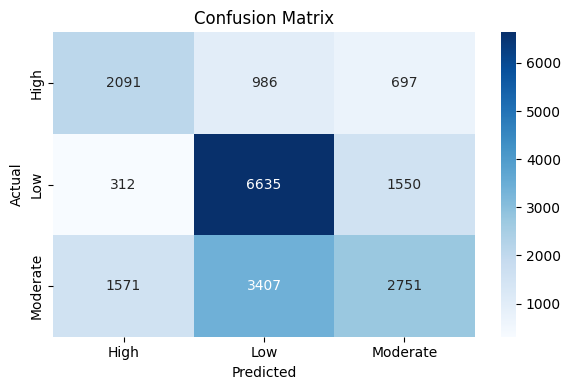

In [1]:
# STEP-0: Install required packages if not already installed
# pip install catboost scikit-learn matplotlib seaborn

import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# STEP-1: Load your dataset
df = pd.read_csv("D:/Diabetes_Unique_Vitals_100k.csv")  # update path if needed
df.drop(columns=["PatientID"], inplace=True)  # drop ID column if present

# STEP-2: Encode target labels
le = LabelEncoder()
df["DiabeticRisk"] = le.fit_transform(df["DiabeticRisk"])  # High/Moderate/Low → 0/1/2

# STEP-3: Identify features
target = "DiabeticRisk"
features = [col for col in df.columns if col != target]
cat_features = df[features].select_dtypes(include='object').columns.tolist()

# STEP-4: Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, stratify=df[target], random_state=42
)

# STEP-5: Convert categorical columns to string and fill NaNs
for col in cat_features:
    X_train[col] = X_train[col].astype(str).fillna("nan")
    X_test[col] = X_test[col].astype(str).fillna("nan")

# STEP-6: Create CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# STEP-7: Train CatBoost Model
model = CatBoostClassifier(
    iterations=600,
    learning_rate=0.045,
    depth=7,
    l2_leaf_reg=4,
    random_strength=2.0,
    bootstrap_type="Bayesian",
    bagging_temperature=1.2,
    rsm=0.8,
    loss_function="MultiClass",
    eval_metric="Accuracy",
    custom_metric=["F1", "Precision", "Recall", "AUC"],
    od_type="Iter",
    od_wait=100,
    auto_class_weights="Balanced",
    one_hot_max_size=4,
    random_seed=42,
    verbose=50
)

model.fit(train_pool, eval_set=test_pool)

# STEP-8: Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# STEP-9: Evaluation
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("✅ Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))
print("✅ Recall (weighted):", recall_score(y_test, y_pred, average='weighted'))
print("✅ ROC AUC (OvR):", roc_auc_score(y_test, y_proba, multi_class='ovr'))

print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# STEP-10: Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


         Feature Id  Importances
0      BloodGlucose    40.173527
1               BMI    35.150202
2  WaistHeightRatio    13.519583
3         HeartRate    11.156687


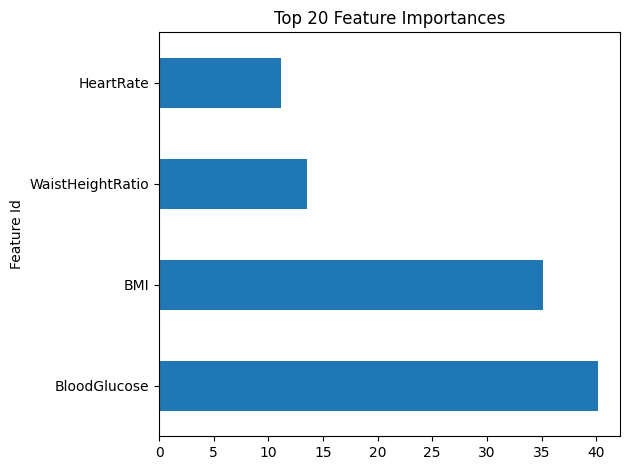

In [2]:
import matplotlib.pyplot as plt

feature_importance = model.get_feature_importance(prettified=True)
print(feature_importance)

# Plot top 20
feature_importance[:20].plot(kind='barh', x='Feature Id', y='Importances', legend=False)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


In [3]:
print(df_train.columns.tolist())


NameError: name 'df_train' is not defined